# Analysis

In [ ]:
pig = bytearray(10000000000)

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from sklearn.metrics import confusion_matrix
import nltk
from nltk.util import ngrams
from bidict import bidict
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from statistics import mean
import sys
import os
import kenlm
from itertools import product
if "/u/solimanz/development/career_prediction_gpu/" not in sys.path:
    sys.path.append("/u/solimanz/development/career_prediction_gpu/")

/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/u/solimanz/development/career_prediction_gpu/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('dark'))

In [58]:
sns.set_palette(sns.color_palette('dark'))

In [3]:
def topK_accs_df(preds, targets, seq_lengths):
    df_dict = {"model": [],
               "length": [],
               "acc": [],
               "top_2_acc": [],
               "top_3_acc": [],
               "top_4_acc": [],
               "top_5_acc": []}
    
    length_groups = groupby_length(seq_lengths)    
    for model, pred in preds.items():
        for k in range(1, 6):
            accs = accuracy_by_length(pred, targets, length_groups, k)
            for length, acc in accs.items():                
                if k == 1:
                    df_dict["acc"].append(round(acc, 5)*100)
                    df_dict["length"].append(length)
                    df_dict["model"].append(model)
                else:
                    df_dict[f"top_{k}_acc"].append(round(acc, 5)*100)
        
    return pd.DataFrame(df_dict)

def groupby_length(seq_lengths):
    d = dict()    
    for i in range(2, seq_lengths.max()+1):
        d[i] = np.where(seq_lengths == i)[0]
        
    return d

def next_batch(path):
    batch = 0
    name = os.path.basename(path)
    while os.path.exists(os.path.join(path, f"{name}_batch_{batch}.npy")):
        with open(os.path.join(path, f"{name}_batch_{batch}.npy"), "rb") as f:
            matrix = np.load(f)
        batch += 1
        yield matrix
        
def accuracy_by_length(preds, targets, groups, k=1):
    """
    preds: predictions of the model (n_examples, max_length, n_labels)
    targets: prediction targets with shape (n_examples, max_lenth, n_labels)
    groups: dictionary grouping the indices of the input sequences by length"""
    
    length_acc = dict()    
    for length, indices in groups.items():
        if len(indices) > 0:
            if len(preds.shape) == 3:
                p = preds[indices, length-1, :]
                t = np.argmax(targets[indices, length-1, :], axis=1)
                length_acc[length] = top_k_acc(p, t, k)
            else:
                p = preds[indices]
                t = targets[indices]
                length_acc[length] = top_k_acc(p, t, k)
        
    return length_acc

def to_python_lists(np_arr, lengths):
    return [row[:length] for row, length in zip(np_arr, lengths)]

def count_transitions(sequences):
    trans = [list(zip(seq[:-1], seq[1:])) for seq in sequences]
    trans = sum(trans, [])
    
    return Counter(trans)

def normalize_counter(counts):
    total = sum(counts.values(), 0)
    for key in counts:
        counts[key] /= total
    
    return counts

def top_k_acc(preds, targets, k=1):
    """
    preds has shape (n_examples, n_labels)
    targets has shape (n_examples, 1)
    """

    sorted_args = (-preds).argsort(axis=1)[:,:k]
    tt = np.tile(targets, (k,1)).T
    acc = np.mean(np.sum(sorted_args == tt, axis=1))
    return acc

def acc_df(preds, targets):
    ks = list(range(1,11))
    df_dict = {"model": [], "top_k": [], "value": []}

    for name, ps in preds.items():
        for k in ks:
            df_dict["model"].append(name)
            df_dict["top_k"].append(k)
            df_dict["value"].append(round(top_k_acc(ps, targets, k), 5)*100)
            
    return pd.DataFrame(df_dict)

def get_ngrams(n, tokens):    
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def get_index(target, top_preds):    
    indices = np.where(top_preds == target)[0]
    if len(indices) == 0:
        return -1
    
    return indices[0]

## Fetching the Results

In [4]:
df_path = "/data/rali7/Tmp/solimanz/data/pickles/excerpt-2017-02-20_reduced.pkl"
base_path = "/data/rali7/Tmp/solimanz/data/"
top550_path = os.path.join(base_path, "datasets", "top550")
reduced7000_path = os.path.join(base_path, "datasets", "reduced7000")
predictions_path = os.path.join(base_path, "model_predictions")

In [5]:
def get_generators(dataset="top550"):
    targets_path = os.path.join(predictions_path, dataset, "jobid", "targets")
    inputs_path = os.path.join(predictions_path, dataset, "jobid", "inputs")
    seq_lengths_path = os.path.join(predictions_path, dataset, "jobid", "seq_lengths")

    bow_predictions_path = os.path.join(predictions_path, dataset, "bow", "predictions")
    jobid_predictions_path = os.path.join(predictions_path, dataset, "jobid", "predictions")
    title_emb_predictions_path = os.path.join(predictions_path, dataset, "title_emb", "predictions")
    
    targets_gen = next_batch(targets_path)
    inputs_gen = next_batch(inputs_path)
    seq_length_gen = next_batch(seq_lengths_path)
    jobid_preds_gen = next_batch(jobid_predictions_path)
    bow_preds_gen = next_batch(bow_predictions_path)
    title_emb_preds_gen = next_batch(title_emb_predictions_path)
    
    return targets_gen, inputs_gen, seq_length_gen, jobid_preds_gen, bow_preds_gen, title_emb_preds_gen

In [6]:
with open(os.path.join(top550_path, "jobid", "data.json"), "r") as f:
    data = json.load(f)

In [7]:
nb_preds_path = "/data/rali7/Tmp/solimanz/data/baseline_preds/best/multi_nb-preds.npy"
nb_targets_path = "/data/rali7/Tmp/solimanz/data/baseline_preds/best/multi_nb-targets.npy"

In [8]:
targets_path = os.path.join(predictions_path, "top550", "jobid", "targets")
inputs_path = os.path.join(predictions_path, "top550", "jobid", "inputs")
seq_lengths_path = os.path.join(predictions_path, "top550", "jobid", "seq_lengths")

bow_predictions_path = os.path.join(predictions_path, "top550", "bow", "predictions")
jobid_predictions_path = os.path.join(predictions_path, "top550", "jobid", "predictions")
title_emb_predictions_path = os.path.join(predictions_path, "top550", "title_emb", "predictions")

In [9]:
targets_gen, inputs_gen, seq_length_gen, jobid_preds_gen, bow_preds_gen, title_emb_preds_gen = get_generators('top550')

In [10]:
targets = []
inputs = []
seq_lengths = []

jobid_preds = []
bow_preds = []
title_emb_preds = []

for i, t, sl, jobid, bow, title_emb in zip(inputs_gen,
                                           targets_gen,
                                           seq_length_gen,
                                           jobid_preds_gen,
                                           bow_preds_gen,
                                           title_emb_preds_gen):
    inputs.append(i)
    targets.append(t)
    seq_lengths.append(sl)
    
    jobid_preds.append(jobid.reshape((jobid.shape[1],jobid.shape[2], jobid.shape[3])))
    bow_preds.append(bow.reshape((bow.shape[1],bow.shape[2], bow.shape[3])))
    title_emb_preds.append(title_emb.reshape((title_emb.shape[1],title_emb.shape[2], title_emb.shape[3])))
    
    

In [11]:
preds = dict()

In [12]:
inputs = np.concatenate(inputs, axis=0)
targets = np.concatenate(targets, axis=0)
seq_lengths = np.concatenate(seq_lengths, axis=0)
preds["jobid"] = np.concatenate(jobid_preds, axis=0)
preds["bow"] = np.concatenate(bow_preds, axis=0)
preds["fasttext"] = np.concatenate(title_emb_preds, axis=0)

In [13]:
z = np.zeros((preds["bow"].shape[0], 1, preds["bow"].shape[2]))
preds["bow"] = np.concatenate([preds["bow"], z], axis=1)
del z

In [14]:
nb_preds = np.load(nb_preds_path)
nb_targets = np.load(nb_targets_path)

In [15]:
xs = to_python_lists(inputs, seq_lengths)
ys = to_python_lists(targets, seq_lengths)
preds["jobid"] = to_python_lists(preds["jobid"], seq_lengths)
preds["bow"] = to_python_lists(preds["bow"], seq_lengths)
preds["fasttext"] = to_python_lists(preds["fasttext"], seq_lengths)

In [16]:
del jobid_preds
del title_emb_preds
del bow_preds

### Focus Analysis on Last Output

In [17]:
ys = np.array([np.argmax(seq[-1], axis=0) for seq in ys])
preds["jobid"] = [seq[-1] for seq in preds["jobid"]]
preds["bow"] = [seq[-1] for seq in preds["bow"]]
preds["fasttext"] = [seq[-1] for seq in preds["fasttext"]]

In [18]:
preds["nb"] = nb_preds

In [19]:
for k, v in preds.items():
    if k != "nb":
        preds[k] = np.array(preds[k])

## Distribution of Labels and Transitions in Training Set

In [20]:
train = data["train_data"]
test = data["test_data"]
title_to_id = bidict(data["title_to_id"])

test_inputs = [[str(i) for i in seq[:-1]] for seq in test]
test_targets = [seq[-1] for seq in test]

#train = [[title_to_id.inv[i] for i in seq] for seq in train]
#test = [[title_to_id.inv[i] for i in seq] for seq in test]

### KenLM

In [21]:
def kenlm_predict(test, model_binary='train_bigram.binary'):    
    model = kenlm.Model(f"../../kenlm/build/{model_binary}")
    model_preds = np.zeros((len(test), 550))
    
    if model_binary == 'train_bigram.binary':
        n = 2
    elif model_binary == 'train_trigram.binary':
        n = 3
    elif model_binary == 'train_4gram.binary':
        n = 4
    elif model_binary == 'train_5gram.binary':
        n = 5
        
    for j, seq in enumerate(test):
        test_seq = seq[-(n-1):]
        for i in range(550):
            model_preds[j][i] = model.score(" ".join(test_seq + [str(i)]))
            
    return model_preds

In [22]:
preds['bigram'] = kenlm_predict(test_inputs, model_binary='train_bigram.binary')
preds['trigram'] = kenlm_predict(test_inputs, model_binary='train_trigram.binary')
preds['4gram'] = kenlm_predict(test_inputs, model_binary='train_4gram.binary')
preds['5gram'] = kenlm_predict(test_inputs, model_binary='train_5gram.binary')

### "Most Common" Predictor

In [ ]:
def train_most_common(sequences, max_n=4):
    ngrams = []
    for seq in sequences:
        for n in range(2, max_n + 1):
            ngrams += get_ngrams(n, seq)
    
    possible_transitions = defaultdict(list)
    ngram_counts = Counter(ngrams)
    
    for ngram, count in ngram_counts.most_common(len(ngram_counts)):
        target = ngram[-1]
        prev_steps = ngram[:-1]
        possible_transitions[prev_steps].append(target)
    
    return ngram_counts, {k: np.array(v) for k, v in possible_transitions.items()}

In [ ]:
def test_most_common(model, test_seqs, k=1):
    predictions = []
    #max_n = max([len(ngram) for ngram in model.keys()])
    
    for seq in test_seqs:
        for i in reversed(range(len(seq))):
            ngram = tuple(seq[-i:])
            if ngram in model:
                predictions.append(model[ngram][k-1])
                break
    
    return predictions

In [ ]:
def predict(model, test, n=2):    
    ngram_model_preds = np.zeros((len(test), 550))
    
    for j, seq in enumerate(test):
        ngram = tuple(seq[-(n-1):])
        for i in range(550):
            ngram_model_preds[j][i] = model.prob(ngram + (i,'<eos>'))
    return ngram_model_preds

def train_ngram_model(train_seqs, n=3):    
    seq_ngrams = sum([list(ngrams(seq, n, pad_right=True, right_pad_symbol='<eos>')) for seq in train_seqs], [])
    freq_dist = nltk.FreqDist(seq_ngrams)
    kneser_ney = nltk.KneserNeyProbDist(freq_dist)
    
    return kneser_ney, seq_ngrams

In [338]:
model, sng = train_ngram_model(train)

In [27]:
preds["fasttext"].shape

(24080, 32, 550)

In [340]:
preds["lm_bigram"] = predict(model, test_inputs)

## Distribution of Sequence Lengths in Test Dataset

In [51]:
train_lengths = [len(t) for t in train]
counts = Counter(train_lengths)
#counts = normalize_counter(counts)

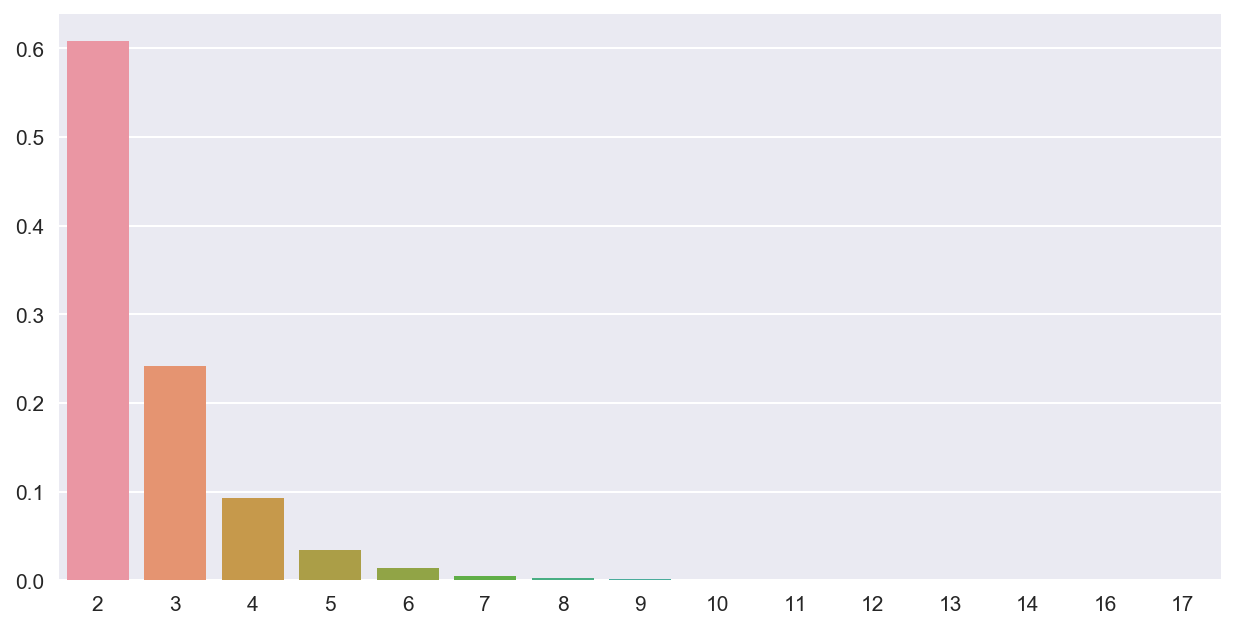

In [59]:
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['figure.dpi'] = 150
ax = sns.barplot(x=list(counts.keys()), y=list(counts.values()))

In [98]:
counts = normalize_counter(Counter(seq_lengths))
unormalized_counts = Counter(seq_lengths)
data = sorted([t for t in counts.items()], key=lambda x: x[0])

In [99]:
unormalized_counts

Counter({2: 14644,
         3: 5813,
         4: 2226,
         5: 823,
         6: 329,
         7: 125,
         8: 62,
         9: 30,
         10: 6,
         11: 9,
         12: 5,
         13: 1,
         14: 4,
         16: 2,
         17: 1})

In [88]:
df = pd.DataFrame({"length": [x[0] for x in data], "frequency": [x[1] for x in data]})

Text(0,0.5,'Frequency')

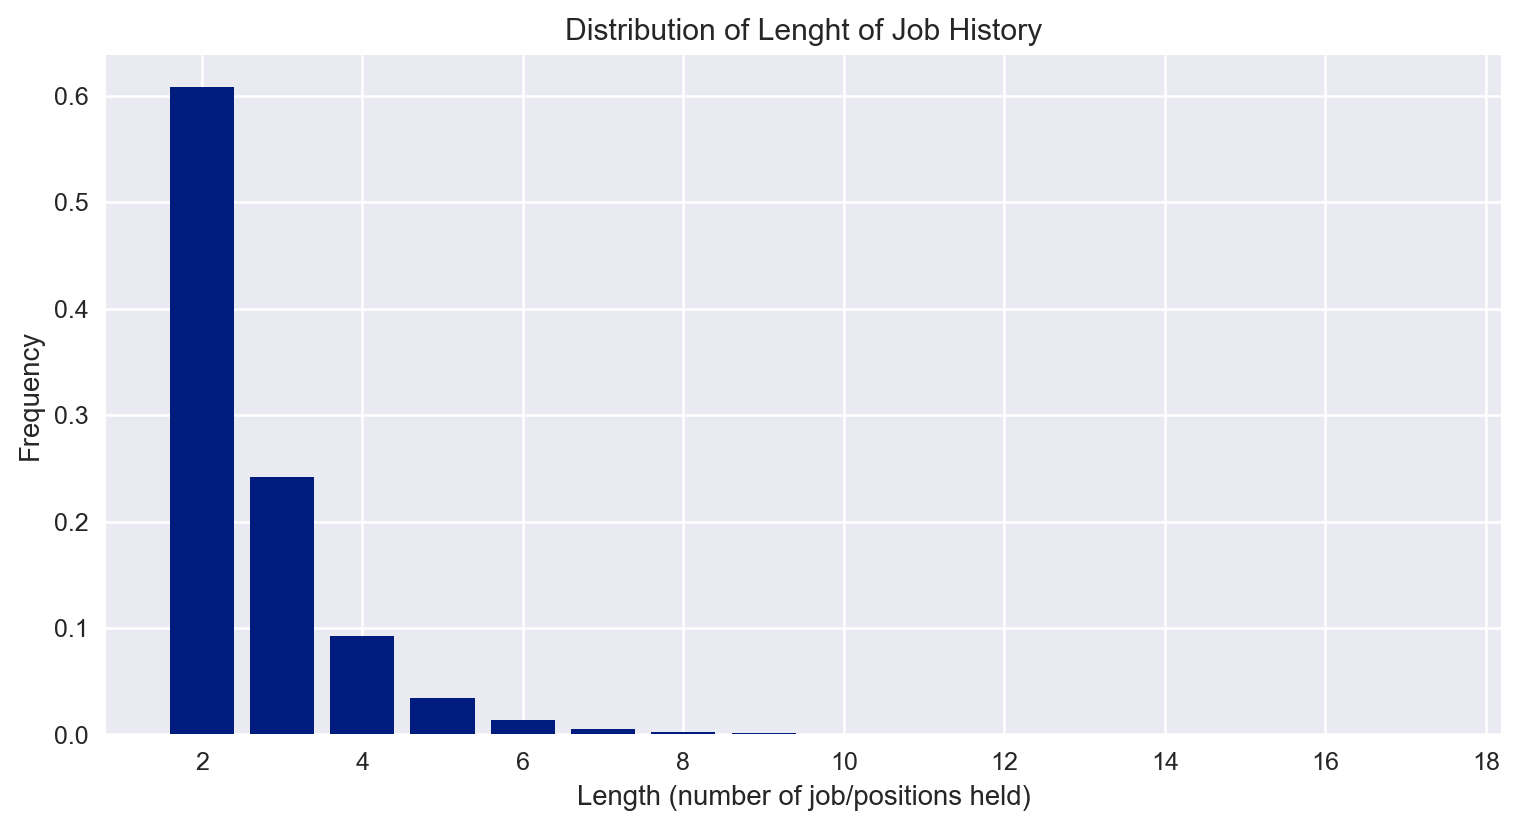

In [91]:
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['figure.dpi'] = 180
plt.bar(x=[x[0] for x in data], height=[x[1] for x in data])
plt.title("Distribution of Lenght of Job History")
plt.xlabel("Length (number of job/positions held)")
plt.ylabel("Frequency")

## Accuracy by length of sequence

In [93]:
df = topK_accs_df(preds, ys, seq_lengths)

In [94]:
def transform(s):
    if s == "bow":
        return "bow_lstm"
    elif s == "jobid":
        return "jobid_lstm"
    elif s == "nb":
        return "Multinomial naive bayes"
    elif s == "title_emb":
        return "title_emb_lstm"
    else:
        return s

df["model"] = df["model"].apply(transform)

In [36]:
df.acc = df.acc.apply(lambda x: x/100)

In [96]:
df = df[df.model.isin(["bigram", "fasttext", "Multinomial naive bayes"])]

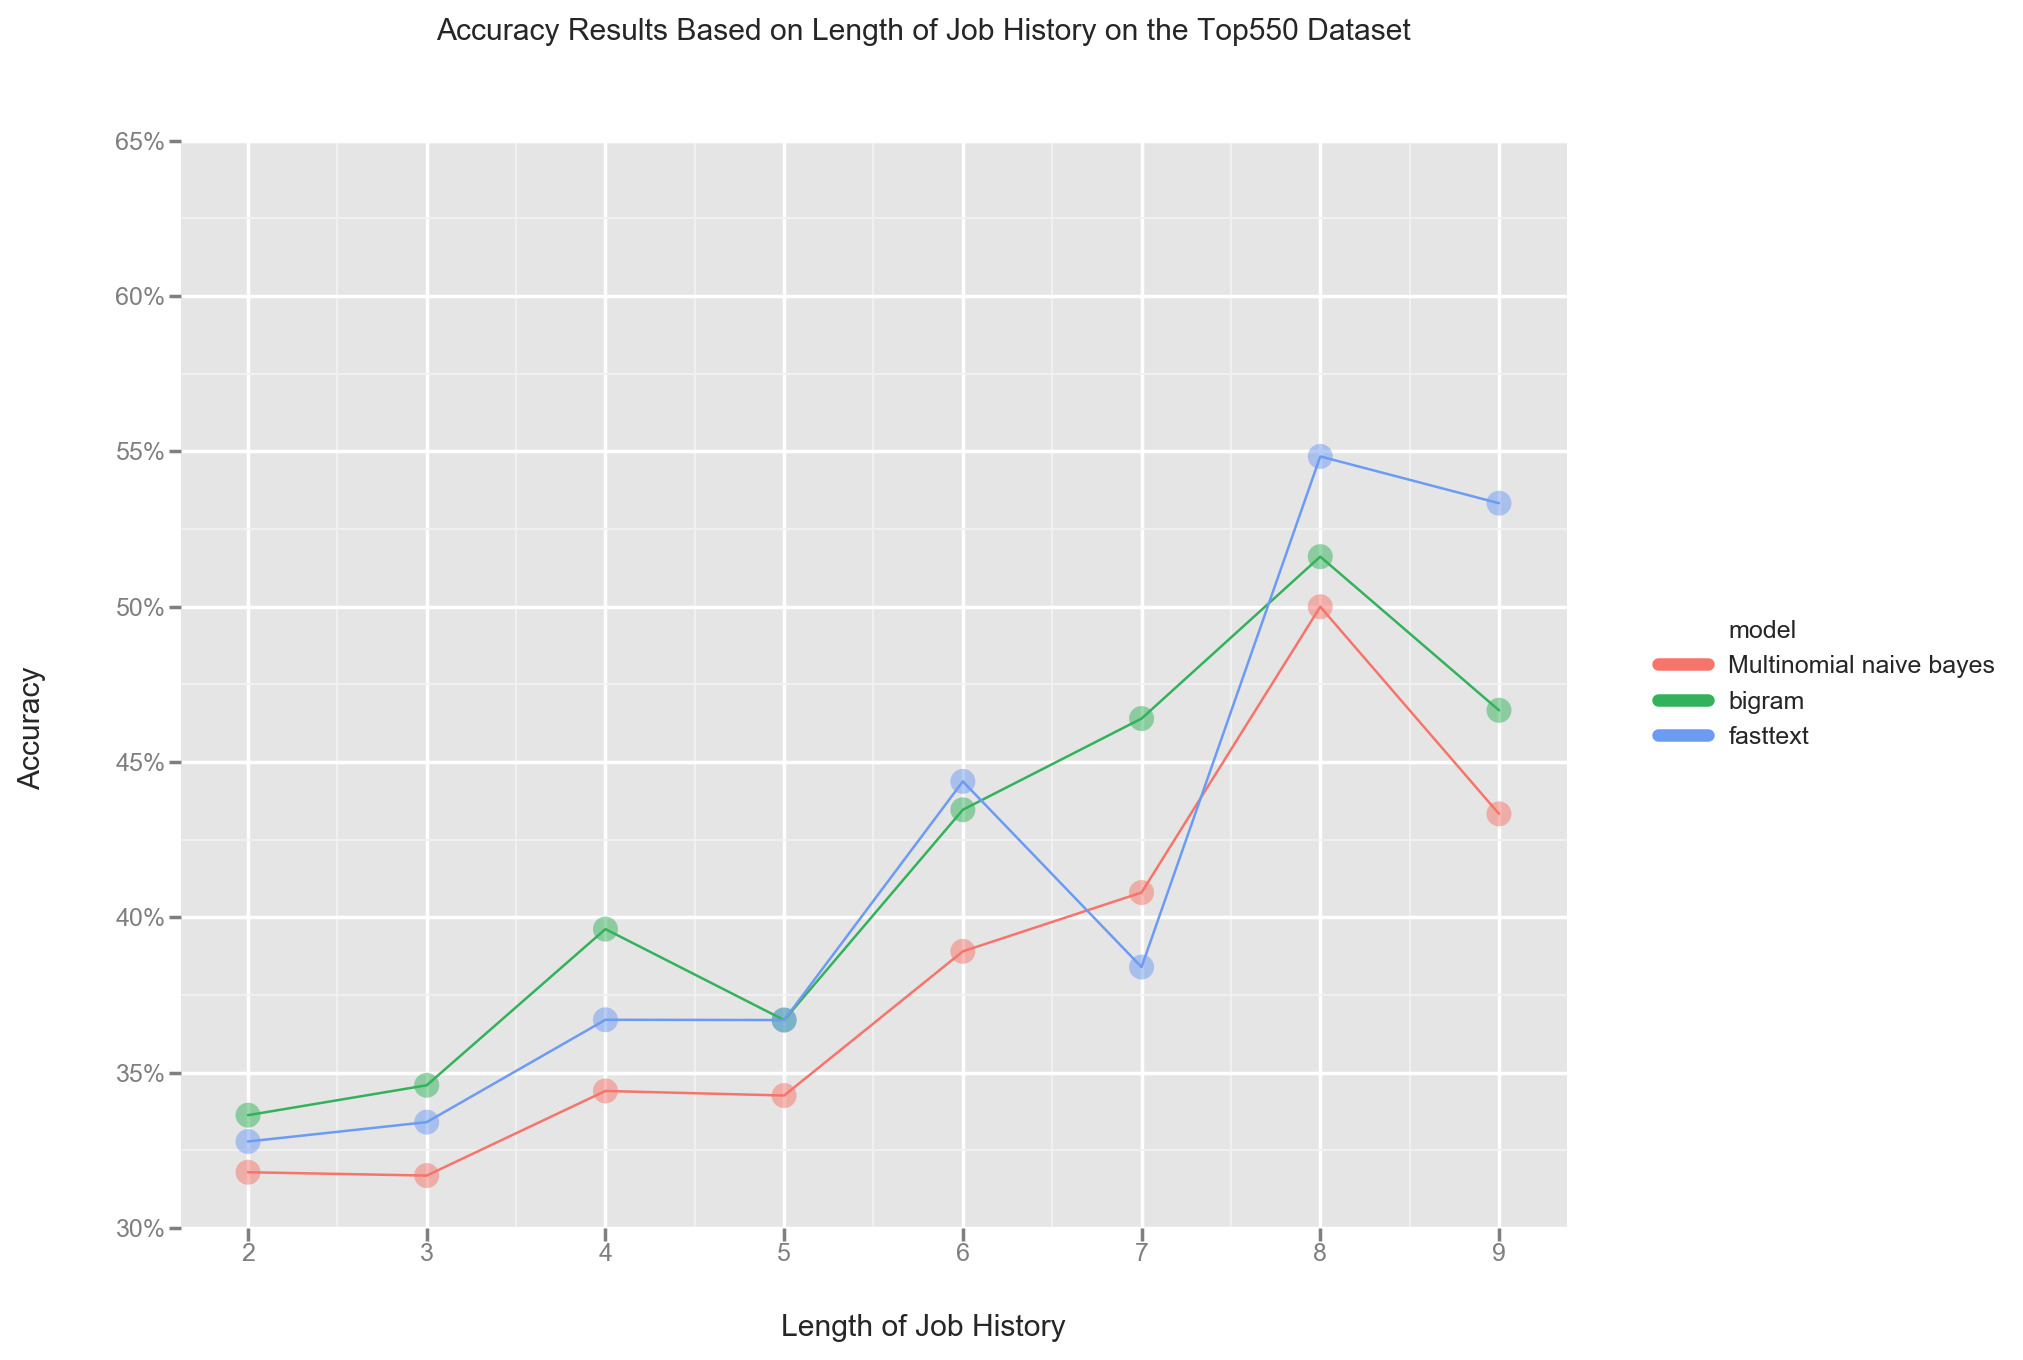

<ggplot: (-9223363281788660280)>

In [97]:
plt.rcParams["figure.figsize"] = 2, 7
plt.rcParams["figure.dpi"] = 180

ggplot(aes(x='length', y='acc', color='model'), data=df[df.length <= 9]) \
+ geom_point(size=100, alpha=0.5) \
+ scale_y_continuous(breaks=[30, 35, 40, 45, 50, 55, 60, 65],
                     labels=['30%', '35%', '40%', '45%', '50%', '55%', '60%', '65%']) \
+ geom_line() \
+ xlab("Length of Job History") \
+ ylab("Accuracy") \
+ ggtitle("Accuracy Results Based on Length of Job History on the Top550 Dataset")

In [48]:
accs = acc_df(preds, ys)
accs.model = accs.model.apply(transform)

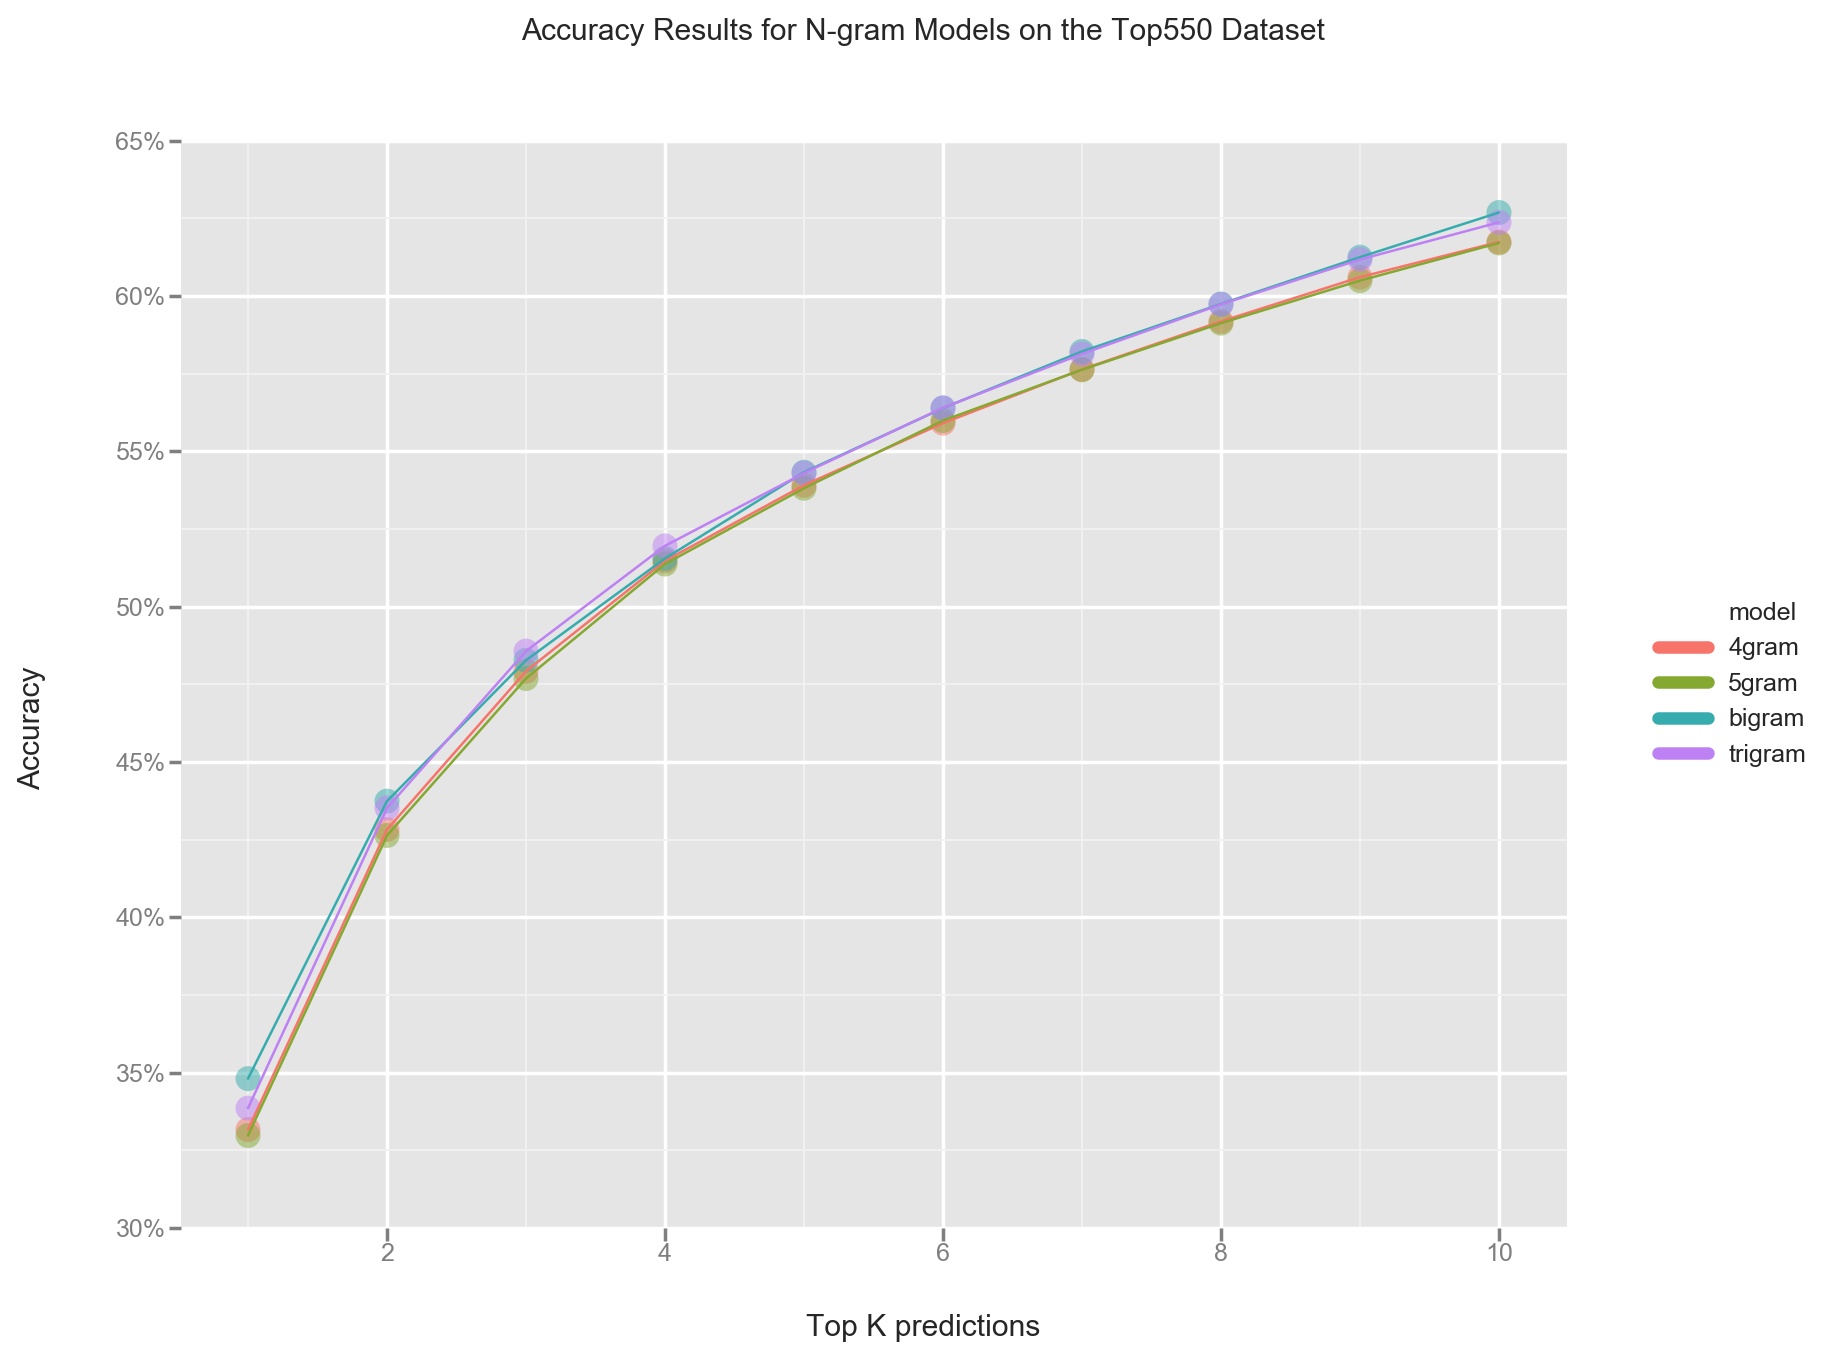

<ggplot: (-9223363281787305391)>

In [47]:
ggplot(aes(x='top_k', y='value', color='model'), data=accs[accs.model.isin(["bigram", "trigram", "4gram", "5gram"])]) \
+ geom_point(size=100, alpha=0.5) \
+ geom_line() \
+ scale_y_continuous(breaks=[30, 35, 40, 45, 50, 55, 60, 65],
                     labels=['30%', '35%', '40%', '45%', '50%', '55%', '60%', '65%']) \
+ xlab("Top K predictions") \
+ ylab("Accuracy") \
+ ggtitle("Top K Accuracy Results for N-gram Models on the Top550 Dataset")

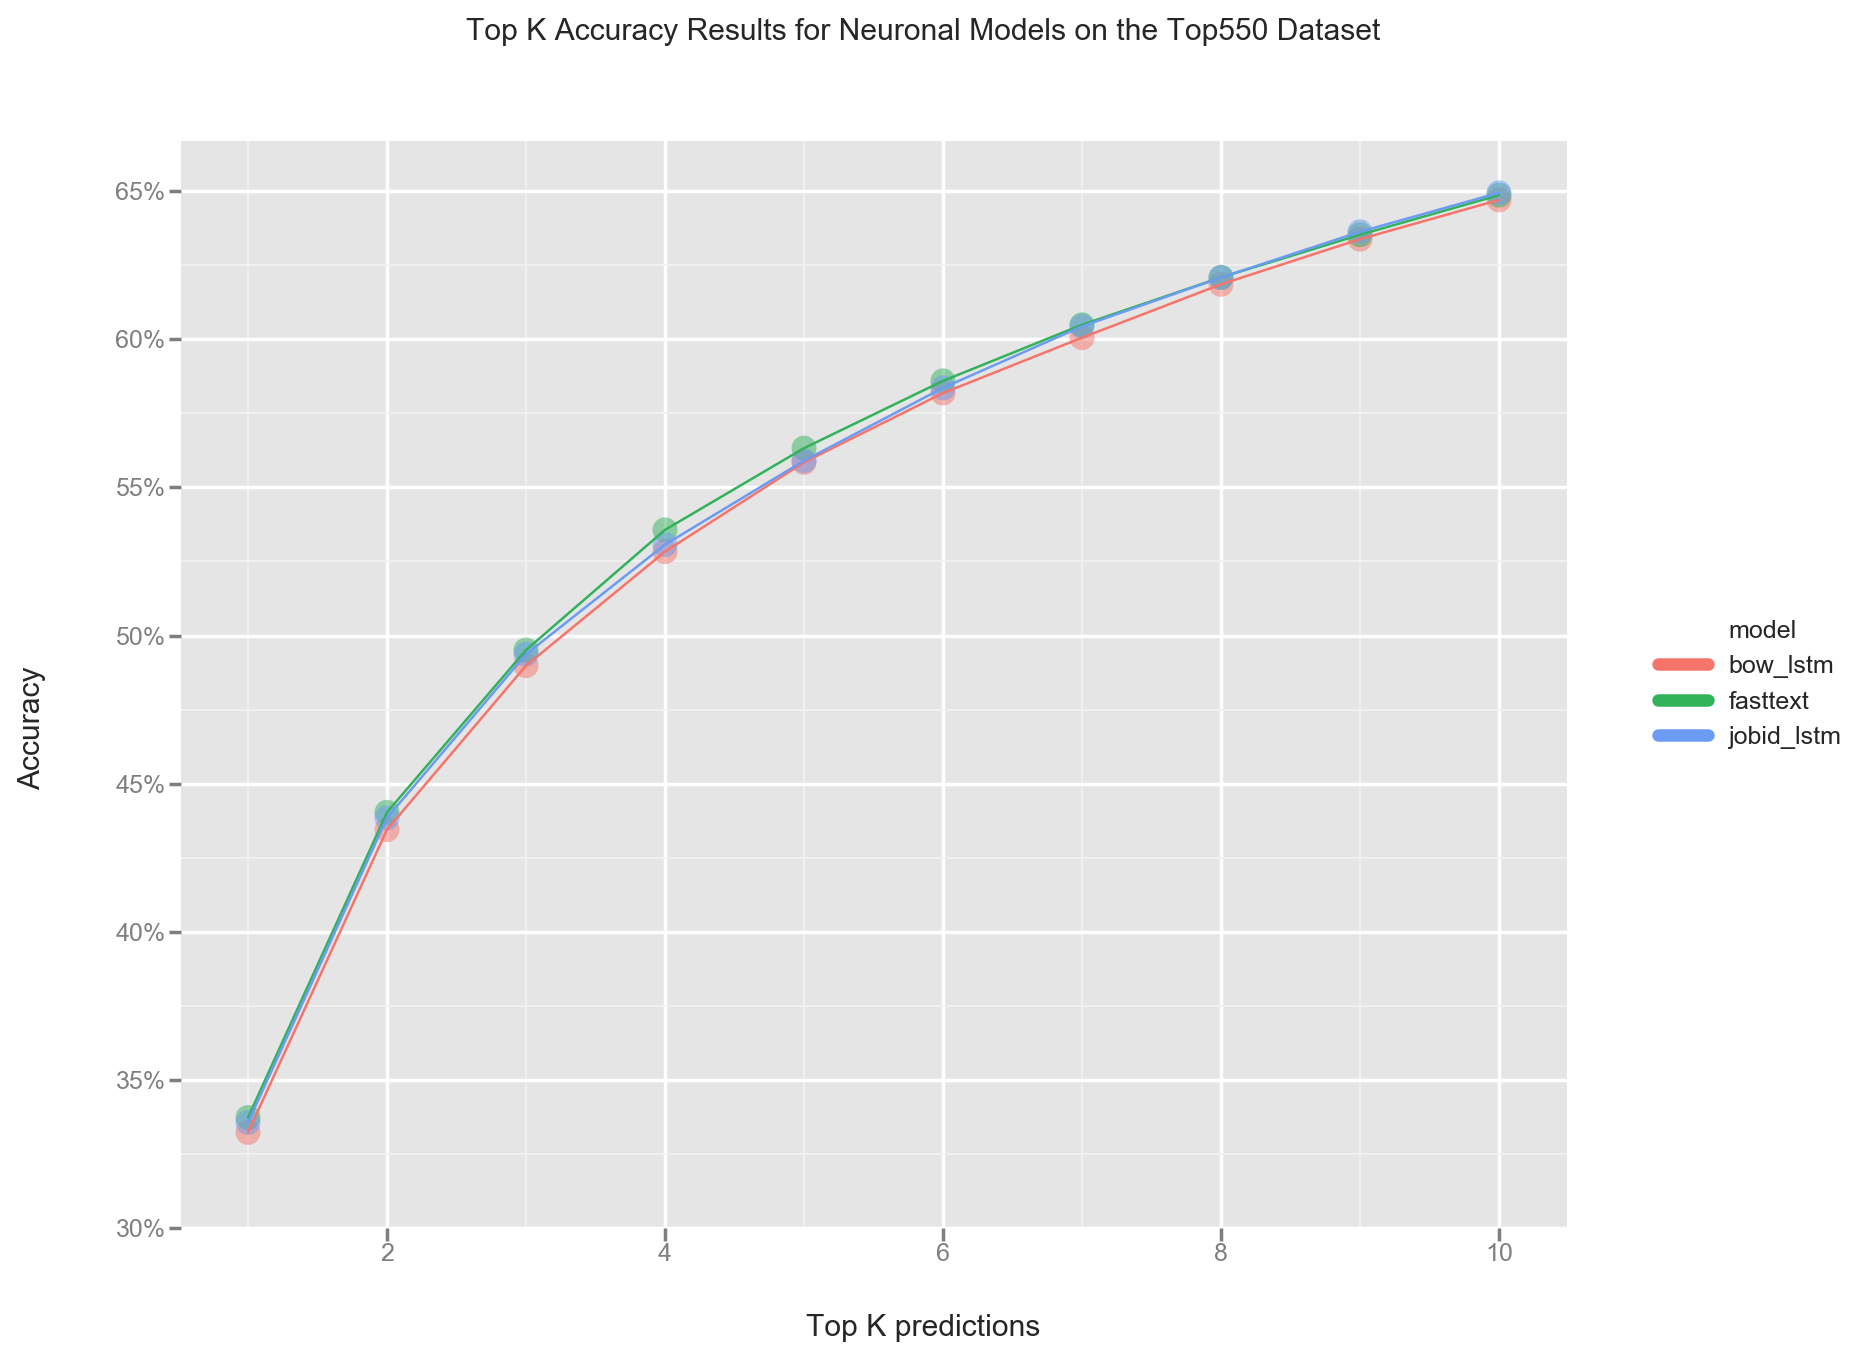

<ggplot: (-9223363281781740961)>

In [50]:
ggplot(aes(x='top_k', y='value', color='model'), data=accs[accs.model.isin(["bow_lstm", "jobid_lstm", "fasttext"])]) \
+ geom_point(size=100, alpha=0.5) \
+ geom_line() \
+ scale_y_continuous(breaks=[30, 35, 40, 45, 50, 55, 60, 65],
                     labels=['30%', '35%', '40%', '45%', '50%', '55%', '60%', '65%']) \
+ xlab("Top K predictions") \
+ ylab("Accuracy") \
+ ggtitle("Top K Accuracy Results for Neuronal Models on the Top550 Dataset")

In [77]:
accs = accs[accs.model.isin(["bigram", "fasttext", "Multinomial naive bayes"])]

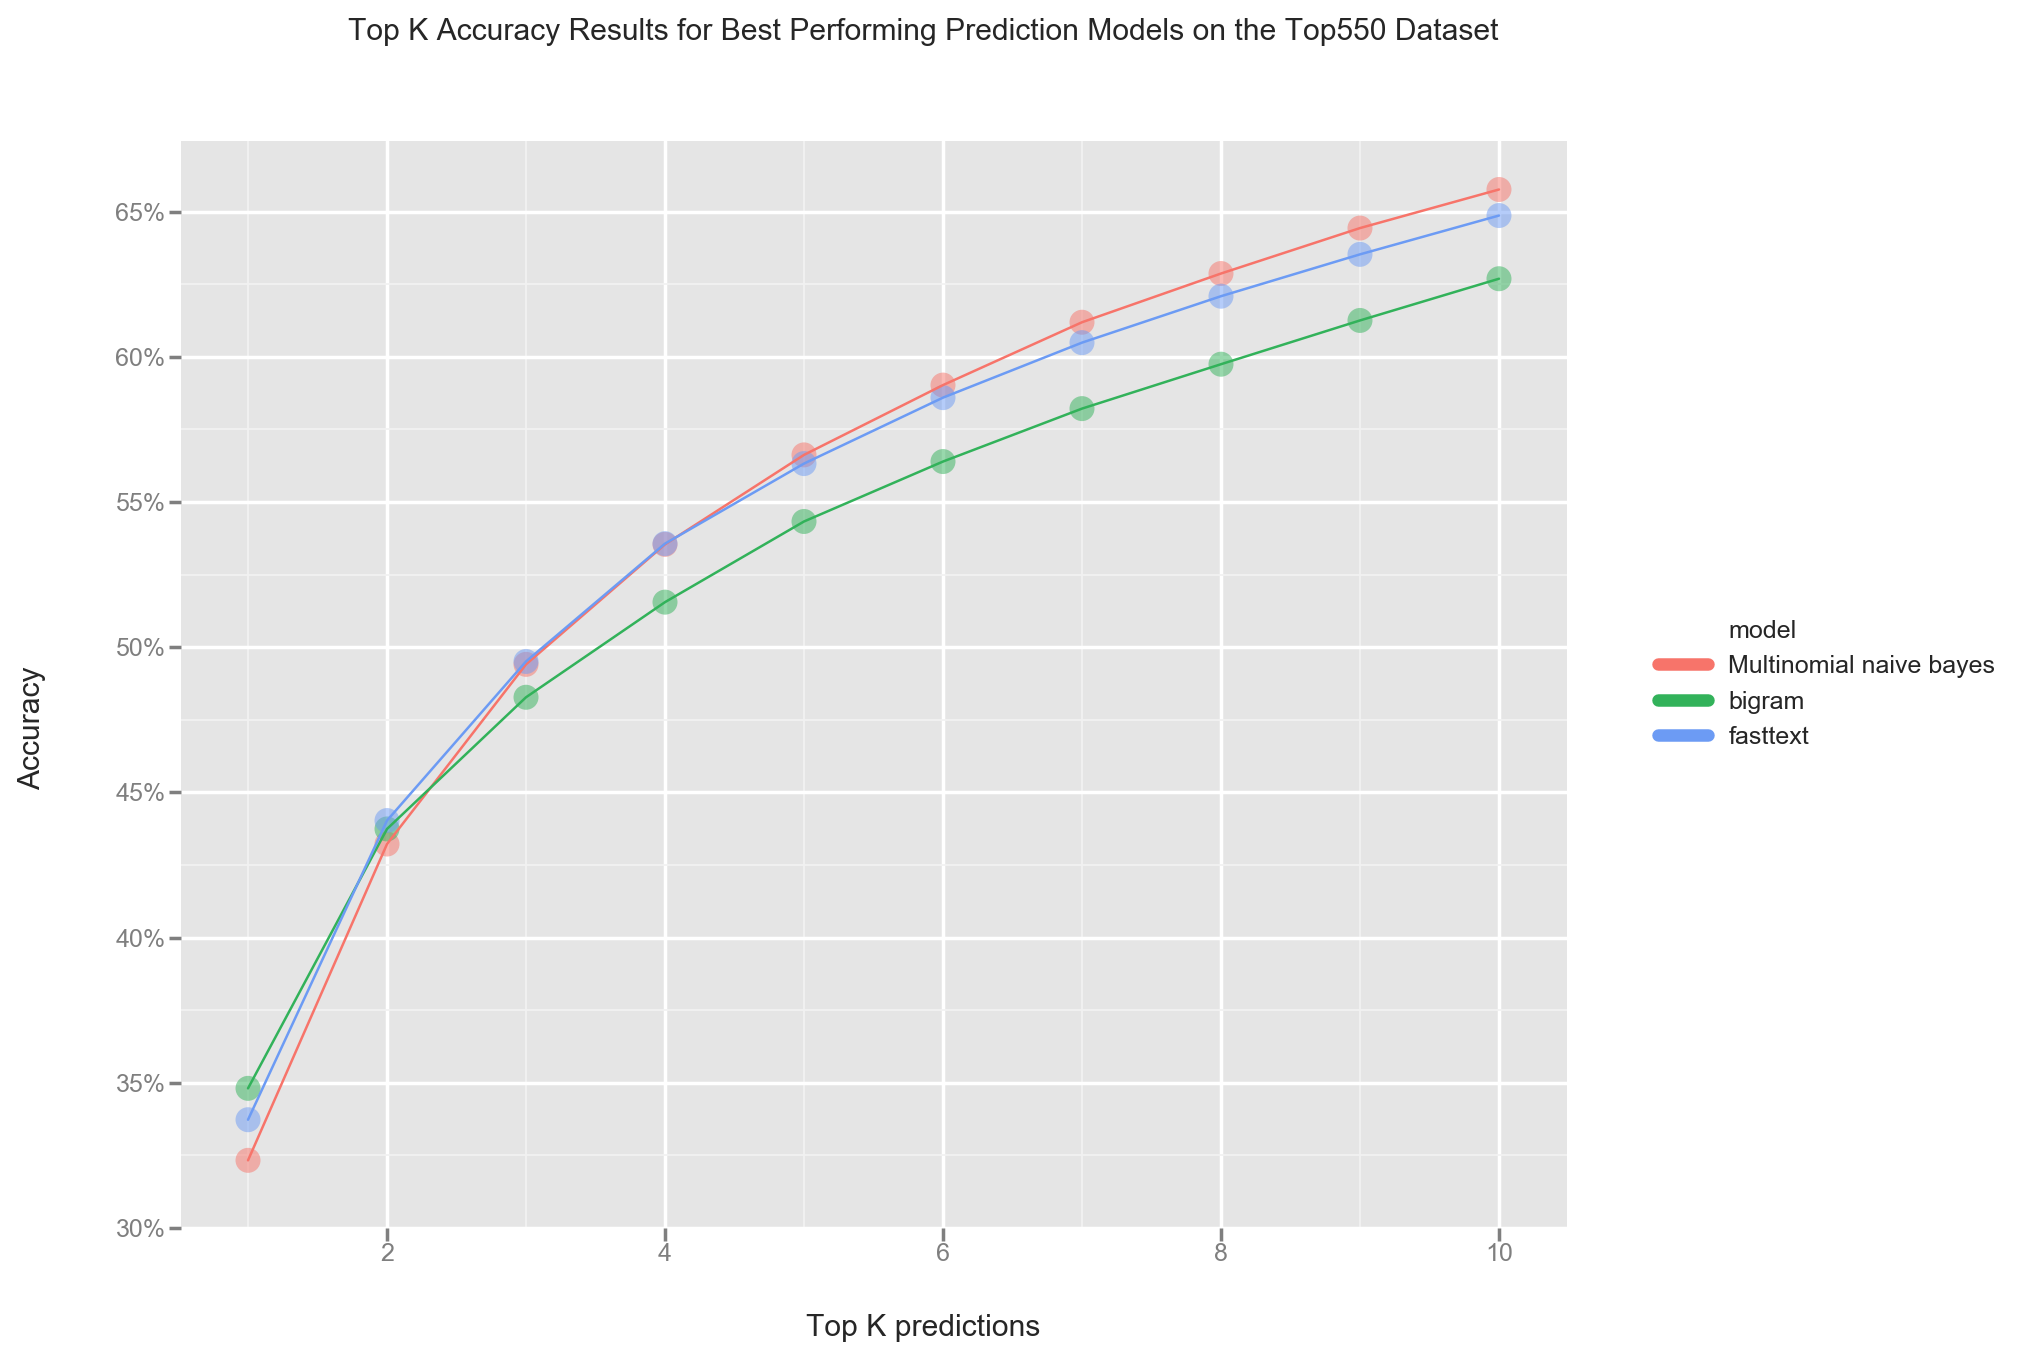

<ggplot: (-9223363281788294396)>

In [78]:
ggplot(aes(x='top_k', y='value', color='model'), data=accs) \
+ geom_point(size=100, alpha=0.5) \
+ geom_line() \
+ scale_y_continuous(breaks=[30, 35, 40, 45, 50, 55, 60, 65],
                     labels=['30%', '35%', '40%', '45%', '50%', '55%', '60%', '65%']) \
+ xlab("Top K predictions") \
+ ylab("Accuracy") \
+ ggtitle("Top K Accuracy Results for Best Performing Prediction Models on the Top550 Dataset")

## Label Predictions

In [86]:
jobid_lst = [seq[-1] for seq in jobid]
bow_lst = [seq[-1] for seq in bow]
fasttext_lst = [seq[-1] for seq in fasttext]
targets_lst = [seq[-1] for seq in ys]

ts = [np.argmax(t) for t in targets_lst]

jobid_lst = [(-preds).argsort(axis=0)[:10]  for preds in jobid_lst]
bow_lst = [(-preds).argsort(axis=0)[:10]  for preds in bow_lst]
fasttext_lst = [(-preds).argsort(axis=0)[:10]  for preds in fasttext_lst]
nb_preds = [(-preds).argsort(axis=0)[:10] for preds in nb_preds]

In [131]:
k = 1

for j, b, f, n, t in zip(jobid_lst, bow_lst, fasttext_lst, nb_preds, ts):
    
    df_dict["jobid_pred"].append(j[k-1])    
    df_dict["bow_pred"].append(b[k-1])
    df_dict["fasttext_pred"].append(f[k-1])
    df_dict["naive_bayes_pred"].append(n[k-1])
    df_dict["target"].append(t)
    
    df_dict["jobid_correct_at"].append(get_index(t, j))
    df_dict["bow_correct_at"].append(get_index(t, b))
    df_dict["fasttext_correct_at"].append(get_index(t, f))
    df_dict["naive_bayes_correct_at"].append(get_index(t, n))
    
for x, t in zip(xs, ts):    
    df_dict["baseline_pred"].append(title_to_id[possible_transitions[title_to_id.inv[x[-1]]][0]])
    df_dict["baseline_correct_at"].append(get_index(title_to_id.inv[t],
                                                    possible_transitions[title_to_id.inv[x[-1]]]))

In [149]:
ordered_preds = dict()

for model, predictions in preds.items():
    ordered_preds[model] = [(-preds).argsort(axis=0)[:10]  for preds in predictions]

In [150]:
df_dict = defaultdict(list)

for model, topK_preds in ordered_preds.items():
    for i, predictions in enumerate(topK_preds):
        df_dict[f"{model}_pred"].append(predictions[0])
        df_dict[f"{model}_correct_at"].append(get_index(ys[i], preds))

df_dict["target"] = list(ys)

In [151]:
df = pd.DataFrame(df_dict)

In [186]:
df.columns

Index(['bow_correct_at', 'bow_pred', 'fasttext_correct_at', 'fasttext_pred',
       'jobid_correct_at', 'jobid_pred', 'lm_4gram_correct_at',
       'lm_4gram_pred', 'lm_5gram_correct_at', 'lm_5gram_pred',
       'lm_bigram_correct_at', 'lm_bigram_pred', 'lm_trigram_correct_at',
       'lm_trigram_pred', 'nb_correct_at', 'nb_pred', 'target'],
      dtype='object')

In [195]:
confusion = confusion_matrix(df.target.values, df.fasttext_pred.values)

In [199]:
confusion.diagonal()

array([ 80, 322, 176, 207, 145, 116, 359, 264, 117,  76,  63,  92,  24,
        51, 112, 197,  26,  55,  56,  80,  34, 129, 125, 137,  35,  27,
        23,  44,  21,  32,  11,  61,  20,  51,  69,  21, 101,  33,   6,
       183,  26,  99,  62,   9,  37,  23, 110,  25,   8,  28,  52,  14,
        12,  23,   7,  38,  11,  40,  14,  42,   4,  58,  14,  15,   5,
        73,   8,   3,  10,   2,  28,  20,   1,  16,  24,   7,  82,  10,
         0,  48,   6,  34,  13,   4,  20,  10,  29,   4,  24,  26,  51,
        24,   4, 136,  30,   0,   1,   6,   8,   0,  15,  14,  92,  13,
        31,   5,  11,   5,  24,   6,  10,   1,  24,   4,   4,  15,   1,
         1,  55,  33,   1,   6,  10,  27,  11,   7,   3,   7,  22,   7,
         2,   5,   1,   8,  13,   5,  15,  25,  10,   8,   3,   7,   9,
         4,   5,   0,   7,   2,   7,  14,   1,  10,   1,  49,  38,   6,
         0,   2,   4,  13,  11,   5,   7,   6,  14,  22,   6,  11,  81,
         2,   6,  24,   0,   3,  24,  43,   0,  11,  18,   3,   

In [215]:
confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

In [218]:
diag = confusion.diagonal()

In [236]:
problematic = np.where(diag <= 0.25)[0]

In [239]:
df = pd.DataFrame({"precision": diag, "label": range(len(diag))})

Text(0.5,0,'Unique Job Title ID Number')

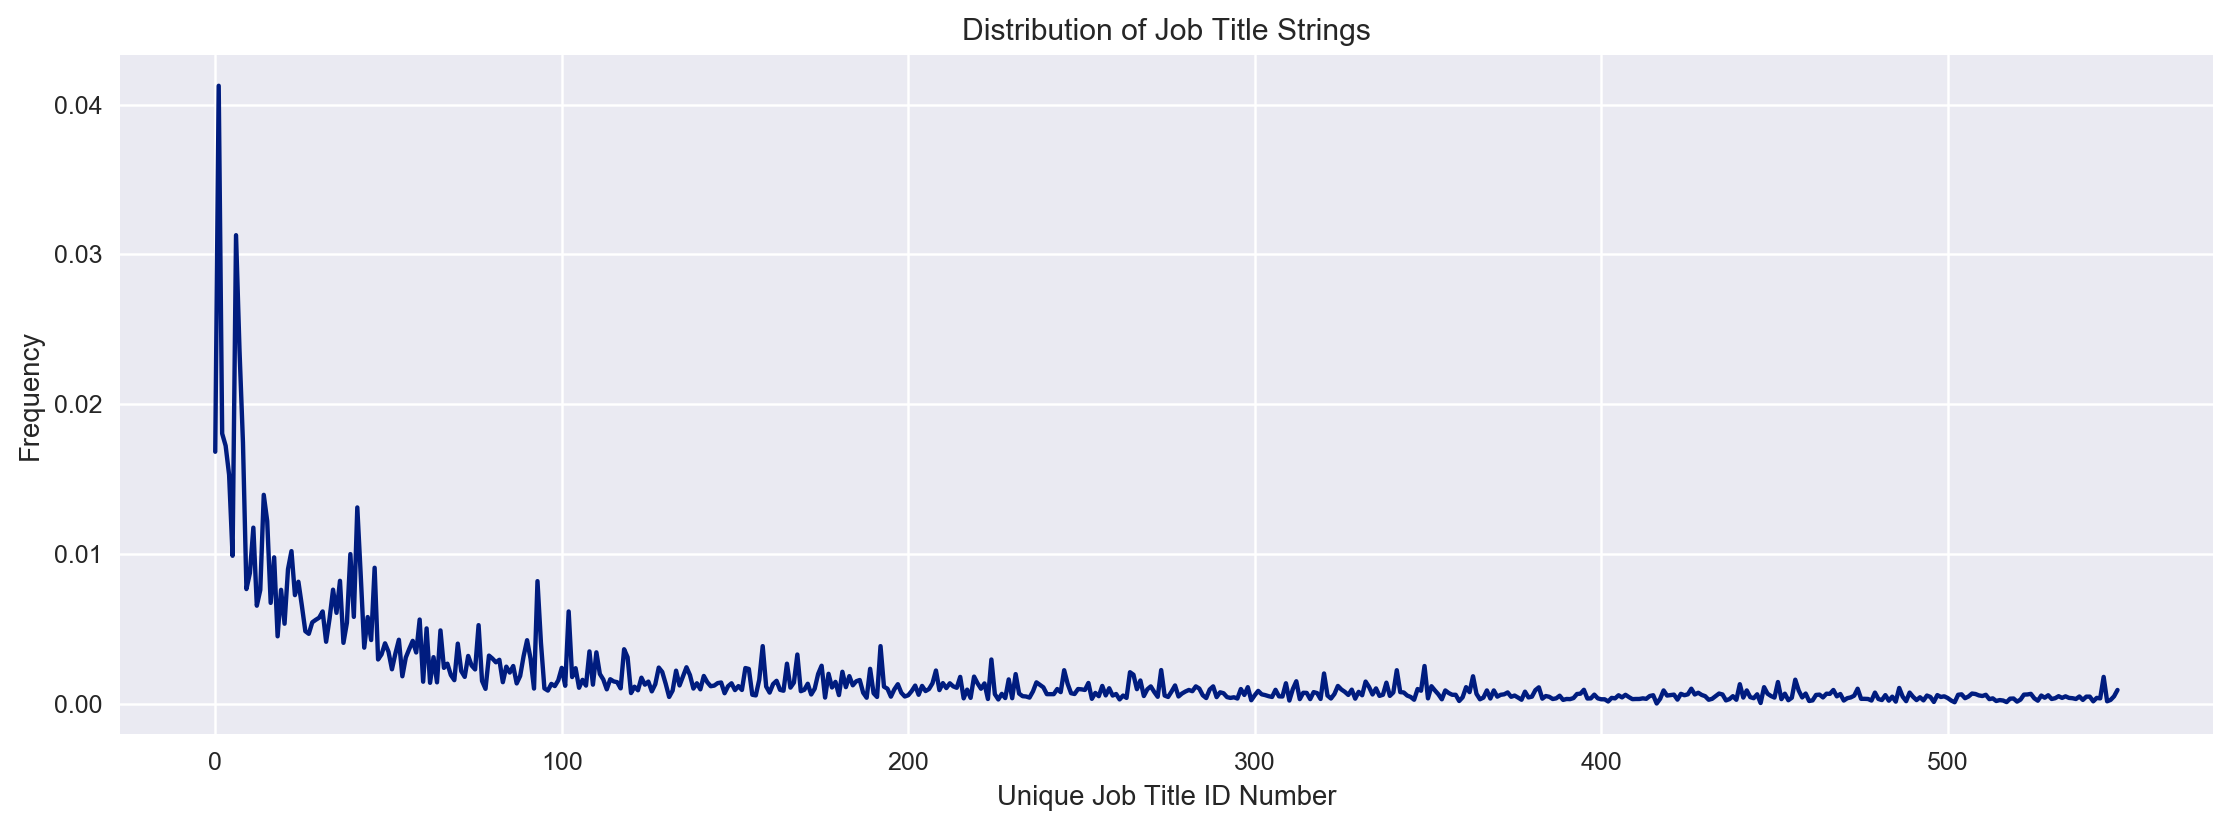

In [75]:
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['figure.dpi'] = 180

label_counts = Counter([seq[-1] for seq in train])
label_counts = normalize_counter(label_counts)
data = sorted([t for t in label_counts.items()], key=lambda x: x[0])

plt.plot([t[0] for t in data],[t[1] for t in data])
plt.title("Distribution of Job Title Strings")
plt.ylabel("Frequency")
plt.xlabel("Unique Job Title ID Number")

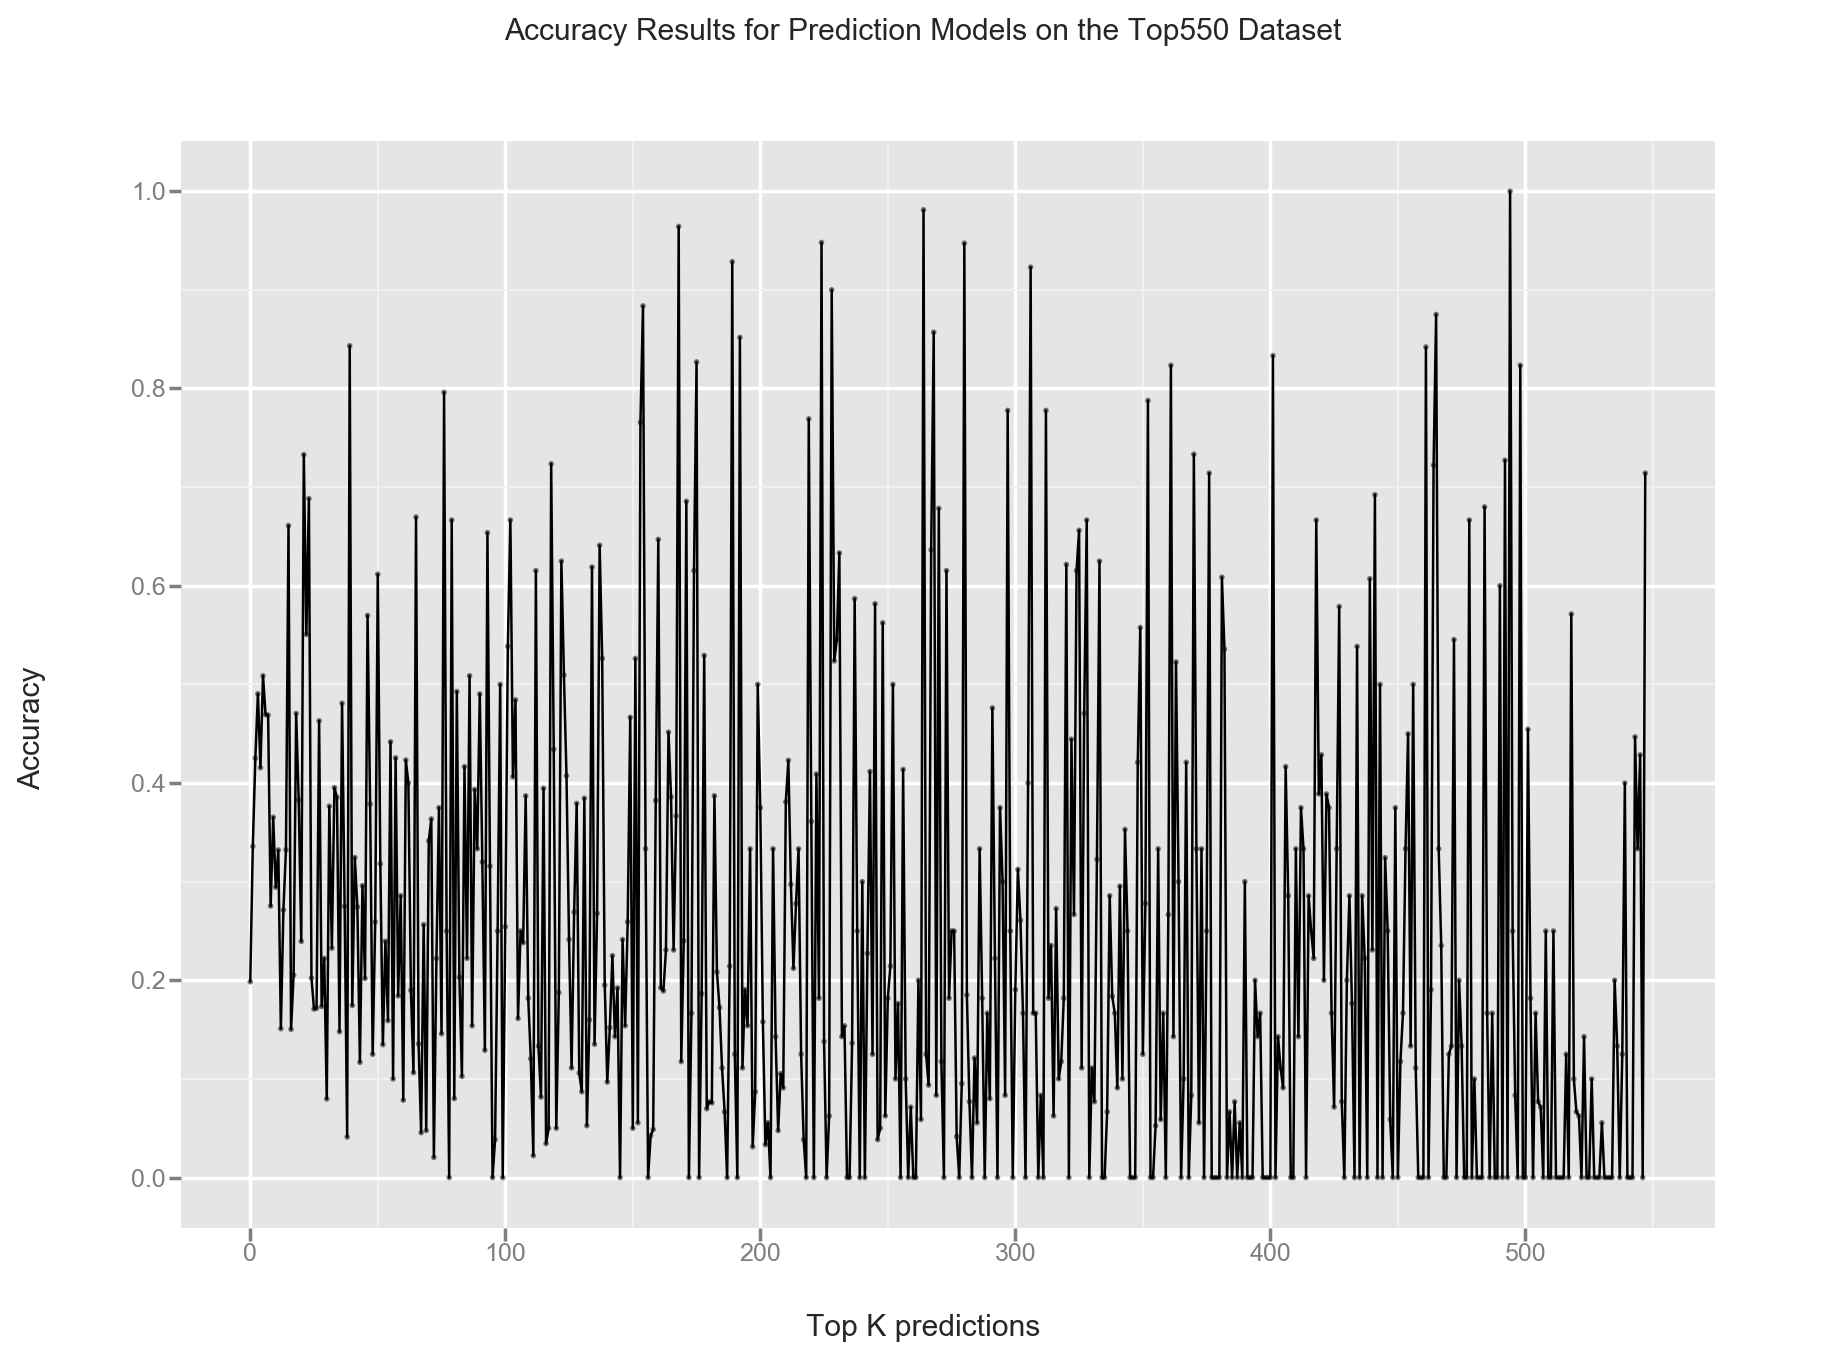

<ggplot: (-9223363290080595603)>

In [244]:
plt.rcParams["figure.figsize"] = 20, 7
plt.rcParams["figure.dpi"] = 180

ggplot(aes(x='label', y='precision'), data=df) \
+ geom_point(size=5, alpha=0.5) \
+ geom_line() \
+ xlab("Top K predictions") \
+ ylab("Accuracy") \
+ ggtitle("Accuracy Results for Prediction Models on the Top550 Dataset")

In [ ]:
def common_preds(labels, cm, title_id, k=10):
    pass

In [100]:
selection = [seq for seq in test if len(seq)==9]

In [105]:
get_ngrams(2, train[9])

[(20, 20), (20, 342)]

In [107]:
transistions = []
for seq in train:
    transistions += get_ngrams(2, seq)

In [110]:
trans_counts = Counter(transistions)

In [112]:
transition_rankings = {t[0]: i + 1 for i, t in enumerate(trans_counts.most_common(len(trans_counts)))}

In [118]:
test_trans = [tuple(seq[-2:]) for seq in selection]

In [123]:
rankings = []

for t in test_trans:
    
    if t in transition_rankings:
        rankings.append(transition_rankings[t])
    else:
        rankings.append(-1)

In [124]:
rankings

[1905,
 3,
 33,
 249,
 6,
 133,
 2589,
 3,
 3344,
 17458,
 403,
 -1,
 3405,
 4,
 51,
 4726,
 25345,
 5699,
 17458,
 1664,
 96,
 305,
 35,
 7590,
 36,
 26,
 243,
 186,
 23,
 1200,
 5178,
 102,
 32036,
 68,
 282,
 151,
 11103,
 29,
 104,
 6,
 1846,
 657,
 18,
 11,
 74,
 4,
 61,
 267,
 811,
 1644,
 20162,
 984,
 10435,
 134,
 33,
 31,
 10727,
 -1,
 11,
 1,
 71,
 57]